# Configuració entorn GPU

In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Càrrega de dades

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'dataBalanced' 

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1168 files belonging to 2 classes.


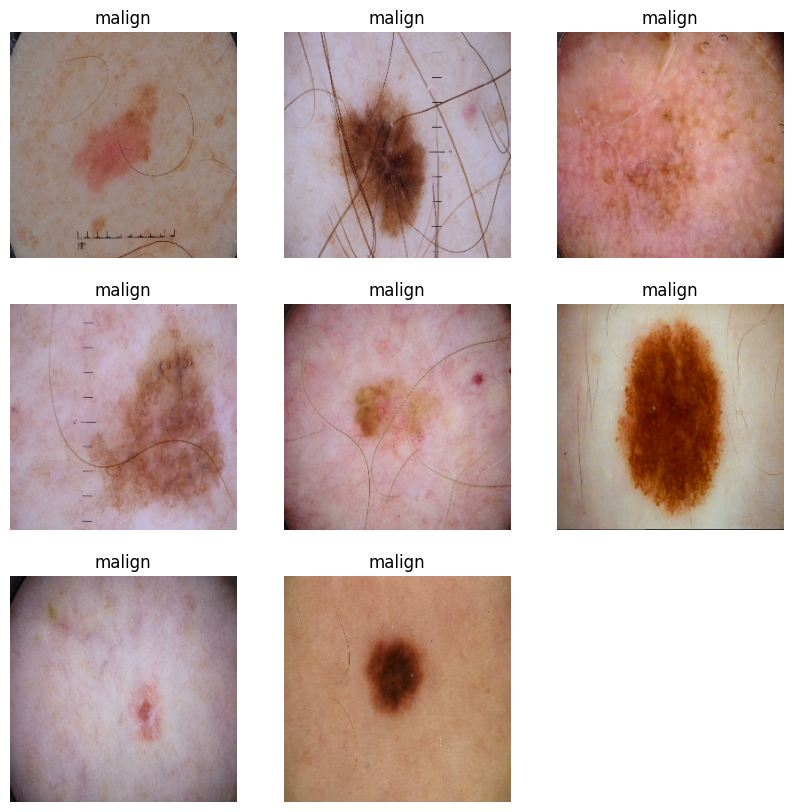

In [8]:
class_names = data.class_names

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val.prefetch(buffer_size=AUTOTUNE)
test_dataset = test.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [13]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [14]:
rescale = tf.keras.layers.Rescaling(scale=1./255)

# Elaboració Model

In [15]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.vgg19.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 512)


In [17]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [19]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [20]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
len(model.trainable_variables)

34

# Entrenament

In [24]:
initial_epochs = 15

#loss0, accuracy0 = model.evaluate(train_dataset)

In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
29/29 [==============================] - 37s 604ms/step - loss: 0.7325 - accuracy: 0.5819 - val_loss: 0.6370 - val_accuracy: 0.6458
Epoch 2/15
29/29 [==============================] - 18s 598ms/step - loss: 0.6214 - accuracy: 0.6444 - val_loss: 0.6090 - val_accuracy: 0.7396
Epoch 3/15
29/29 [==============================] - 18s 607ms/step - loss: 0.5752 - accuracy: 0.7188 - val_loss: 0.4778 - val_accuracy: 0.7917
Epoch 4/15
29/29 [==============================] - 18s 613ms/step - loss: 0.5384 - accuracy: 0.7338 - val_loss: 0.5105 - val_accuracy: 0.7396
Epoch 5/15
29/29 [==============================] - 18s 602ms/step - loss: 0.5380 - accuracy: 0.7112 - val_loss: 0.5560 - val_accuracy: 0.7500
Epoch 6/15
29/29 [==============================] - 18s 600ms/step - loss: 0.5181 - accuracy: 0.7328 - val_loss: 0.4445 - val_accuracy: 0.8021
Epoch 7/15
29/29 [==============================] - 18s 601ms/step - loss: 0.5343 - accuracy: 0.7338 - val_loss: 0.3972 - val_accuracy: 0.8333

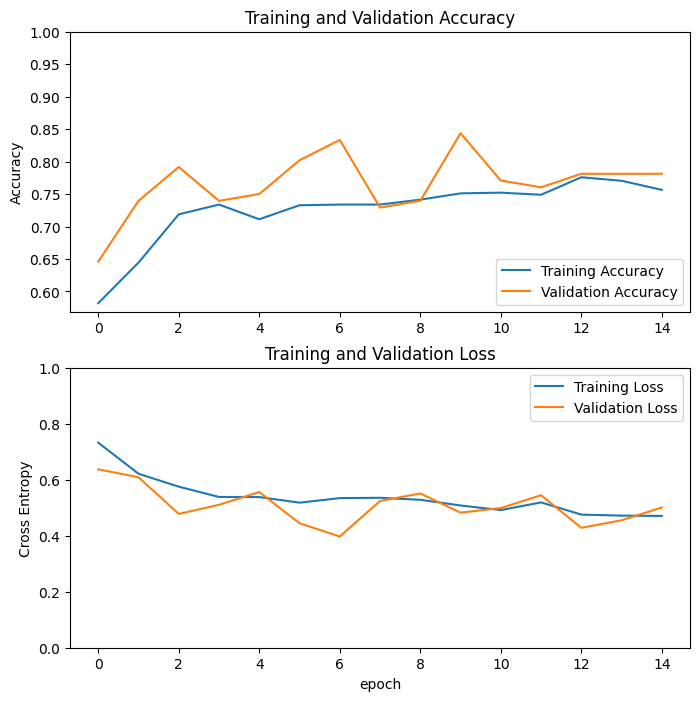

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Avaluació

In [27]:
loss, accuracy = model.evaluate(test_dataset)

3/3 [==============================] - 3s 98ms/step - loss: 0.4844 - accuracy: 0.8125


In [28]:
from tensorflow.keras.metrics import Precision, Recall, AUC
pre = Precision()
re = Recall()
auc = AUC()
y_vec = []
yhat_vec = []
for batch in test_dataset.as_numpy_iterator(): 
    X, y = batch
    y_vec.append(y)
    #print(y)
    yhat = model.predict(X)
    yhat_vec.append(yhat)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    auc.update_state(y, yhat)
    

1/1 [==============================] - 0s 16ms/step


In [29]:
print(pre.result(), re.result(), auc.result())

tf.Tensor(0.8596491, shape=(), dtype=float32) tf.Tensor(0.9074074, shape=(), dtype=float32) tf.Tensor(0.8880071, shape=(), dtype=float32)


In [32]:
precision = 0.8596491
recall = 0.9074074
F1 = 2/((1/precision)+(1/recall))
print(F1)

0.8828828673484295
